In [80]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

In [81]:
train = pd.read_csv('train_preprocessed.csv')
test = pd.read_csv('test_preprocessed.csv')

### Scaling numerical features

In [82]:
num_features = [ 'mainland_nights', 'island_nights', 'ratio', 'total_nights', 'male_count', 'female_count', 'total_travellers']

In [83]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train[num_features] = scaler.fit_transform(train[num_features])
test[num_features] = scaler.transform(test[num_features])

In [84]:
# train test split with stratify
X = train.drop(columns=['category'])
y = train['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

## Logistic Regression

In [ ]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced')

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2'],
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)
y_pred = grid_search.best_estimator_.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Validation F1 Score:", f1)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 10, 'penalty': 'l2'}
Best Score: 0.655031847133758
Validation F1 Score: 0.6540507183279345


In [ ]:
# now train with the entire data

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced')

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2'], 
}

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(train.drop(columns=['category']), train['category'])

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'C': 10, 'penalty': 'l2'}
Best Score: 0.6556608158163538


In [ ]:
train_columns = [col for col in train.columns if col != 'category']

test_reordered = test[train_columns]
test_reordered

preds = pd.concat([test['trip_ID'], pd.Series(log_reg.predict(test_reordered))], axis=1)
preds.columns = ['trip_ID', 'category']
preds.to_csv("submission.csv", index=False)

## Random forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.utils.class_weight import compute_sample_weight

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train['category']
)

f1 = make_scorer(f1_score, average='weighted')

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  
    scoring=f1,
    cv=3,  
    verbose=1,
    n_jobs=-1,  
    random_state=42
)

random_search_rf.fit(X, y, sample_weight=sample_weights)

best_rf_model = random_search_rf.best_estimator_

y_pred = best_rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Validation F1 Score:", f1)

print(random_search_rf.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Validation F1 Score: 0.8840494680445983
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'class_weight': None, 'bootstrap': True}


In [ ]:
# now creating the model on the entire data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.utils.class_weight import compute_sample_weight

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train['category']
)

f1 = make_scorer(f1_score, average='weighted')

random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  
    scoring=f1,
    cv=3,  
    verbose=1,
    n_jobs=-1,  
    random_state=42
)

random_search_rf.fit(train.drop(columns=['category']), train['category'], sample_weight=sample_weights)

best_rf_model = random_search_rf.best_estimator_

print(random_search_rf.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dyuthi/anaconda3/lib/python3

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': None, 'class_weight': None, 'bootstrap': True}


## XGBoost

In [88]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, objective='multi:softmax',num_class=3)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5], 
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


f1 = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50, 
    scoring=f1,
    cv=3,  
    verbose=1,
    n_jobs=-1, 
    random_state=42
)


sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

random_search.fit(X_train,y_train, sample_weight=sample_weights)
best_xgb_model = random_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print(random_search.best_params_)
print("Validation F1 Score:", f1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/dyuthi/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dyuthi/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dyuthi/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dyuthi/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:33:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dyuthi/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [23:33:34] WARNING: /worksp

{'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Validation F1 Score: 0.7285829983305849


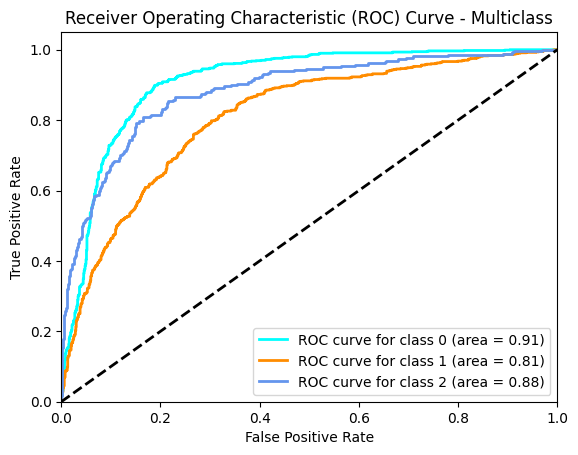

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2]) 

y_score = best_xgb_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multiclass')
plt.legend(loc="lower right")
plt.show()


In [85]:
# now training the model with entire data

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42, objective='multi:softmax',num_class=3)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5],  
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=train['category']
)

f1 = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=50, 
    scoring=f1,
    cv=3,  #
    verbose=1,
    n_jobs=-1, 
    random_state=42
)


sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train['category'])

random_search.fit(train.drop(columns=['category']),train['category'], sample_weight=sample_weights)

best_xgb_model = random_search.best_estimator_

print(random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dyuthi/anaconda3/lib/python3

{'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [86]:
train_columns = [col for col in train.columns if col != 'category']

test_reordered = test[train_columns]

preds = pd.concat([test['trip_ID'], pd.Series(best_xgb_model.predict(test_reordered))], axis=1)
preds.columns = ['trip_ID', 'category']
preds.to_csv("submission.csv", index=False)

## GBM Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

gbm = GradientBoostingClassifier(random_state=42)

# Define the parameter grid for tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
f1 = make_scorer(f1_score, average='weighted')

# hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=param_dist,
    n_iter=50, 
    scoring=f1,
    cv=3,  
    verbose=1,
    n_jobs=-1, 
    random_state=42
)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

random_search.fit(X_train,y_train, sample_weight=sample_weights)

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)


f1 = f1_score(y_test, y_pred, average='weighted')

print("Best Parameters:", random_search.best_params_)
print("Validation F1 Score:", f1)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'learning_rate': 0.01}
Validation F1 Score: 0.7238812752225575


In [ ]:
# now training the model with entire data

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

gbm = GradientBoostingClassifier(random_state=42)

# Define the parameter grid for tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

f1 = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=param_dist,
    n_iter=50, 
    scoring=f1,
    cv=3,  
    verbose=1,
    n_jobs=-1, 
    random_state=42
)

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train['category'])

random_search.fit(train.drop(columns=['category']),train['category'], sample_weight=sample_weights)

best_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)


In [ ]:
train_columns = [col for col in train.columns if col != 'category']

test_reordered = test[train_columns]

preds = pd.concat([test['trip_ID'], pd.Series(best_model.predict(test_reordered))], axis=1)
preds.columns = ['trip_ID', 'category']
preds.to_csv("prediction6.csv", index=False)

## LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

lgbm = lgb.LGBMClassifier(objective='multiclass', random_state=42)

param_dist = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

f1 = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50, 
    scoring=f1,
    cv=5, 
    verbose=1,
    n_jobs=-1,  
    random_state=42
)

model = lgb.LGBMClassifier(objective='multiclass', random_state=1)
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train)

random_search.fit(X_train,y_train ,sample_weight=sample_weights)


best_model = random_search.best_estimator_

# Predict on the validation set with the best model
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')

print("Best Parameters:", random_search.best_params_)
print("Validation F1 Score:", f1)


In [61]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

lgbm = lgb.LGBMClassifier(objective='multiclass', random_state=42)

param_dist = {
    'num_leaves': [15, 31],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

f1 = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,  
    scoring=f1,
    cv=5, 
    verbose=1,
    random_state=42
)

model = lgb.LGBMClassifier(objective='multiclass', random_state=1)
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train['category'])

random_search.fit(train.drop(columns=['category']),train['category'], sample_weight=sample_weights)

best_model = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 7850, number of used features: 27
[LightGBM] [Info] Start training from score -1.098470
[LightGBM] [Info] Start training from score -1.098650
[LightGBM] [Info] Start training from score -1.098718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

In [ ]:
train_columns = [col for col in train.columns if col != 'category']

test_reordered = test[train_columns]

preds = pd.concat([test['trip_ID'], pd.Series(best_model.predict(test_reordered))], axis=1)
preds.columns = ['trip_ID', 'category']
preds.to_csv("lgbm.csv", index=False)

## Adaboost

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train['category'])

base_estimator = DecisionTreeClassifier(random_state=42)

ada = AdaBoostClassifier(estimator=base_estimator, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X,y,sample_weight=sample_weights)

y_pred= grid_search.best_estimator_.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)
print("Validation F1 Score:", f1)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.2s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.3s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.3s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.3s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.9s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.8s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.8s
[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=50; total time=   1.5s
[CV] END estimator__max_depth=1, learning_rat

In [67]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=train['category'])

base_estimator = DecisionTreeClassifier(random_state=42)

ada = AdaBoostClassifier(estimator=base_estimator, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'estimator__max_depth': [1, 2, 3]
}

grid_search = GridSearchCV(
    estimator=ada,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train.drop(columns=['category']),train['category'],sample_weight=sample_weights)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/dyuthi/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/home/dyuthi/anaconda3/lib/python3

[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.5s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.3s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.7s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=50; total time=   1.5s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.3s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.4s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.1s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.4s
[CV] END estimator__max_depth=1, learning_rate=0.01, n_estimators=100; total time=   2.2s
[CV] END estimator__max_depth=1, learning_rate=0.1, n_estimators=50; total time=   1.1s
[CV] END estimato

In [ ]:
train_columns = [col for col in train.columns if col != 'category']

test_reordered = test[train_columns]

test_predictions = grid_search.best_estimator_.predict(test_reordered)

output = pd.DataFrame({
    'trip_ID': test['trip_ID'],  
    'category': test_predictions
})

# Save to CSV
output.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


## Ensemble

In [65]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

gbm_parameters = {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10, 'learning_rate': 0.05}
lgbm_parameters = {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

xgb_parameters = {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

xgboost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, **xgb_parameters)
gbm = GradientBoostingClassifier(**gbm_parameters, random_state=42)
lightgbm = LGBMClassifier(**lgbm_parameters, random_state=42)

ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgboost),
        ('gbm', gbm),
        ('lgbm', lightgbm)
    ],
    voting='soft'
)

In [66]:
ensemble_model.fit(train.drop(columns=['category']),train['category'], sample_weight=sample_weights)

train_columns = [col for col in train.columns if col != 'category']

# Reorder test columns to match train (excluding 'trip_ID')
test_reordered = test[train_columns]

preds = pd.concat([test['trip_ID'], pd.Series(ensemble_model.predict(test_reordered))], axis=1)
preds.columns = ['trip_ID', 'category']
preds.to_csv("ensemble.csv", index=False)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 425
[LightGBM] [Info] Number of data points in the train set: 9813, number of used features: 27
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L